In [19]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from QLearning import QLearningAgent

In [20]:
# Parâmetros do treinamento
N = 5  # Número de repetições do treinamento
num_eval = 100
num_episodes = 1000
max_steps = 1300

# Lista para armazenar recompensas de todas as execuções
ql_mean_rewards = []

In [21]:
# Loop de treinamentos (N vezes)
for i in range(N):
    print(f"Treinamento {i+1}/{N} iniciado...")
    
    # Cria o ambiente e inicializa o agente
    env = gym.make("MountainCar-v0")
    agent = QLearningAgent(env, alpha=0.1, gamma=0.99, 
                           epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.01)

    # Treina o agente
    agent.train(num_episodes=num_episodes, max_steps_per_episode=max_steps)

    # Armazena os dados para a curva de aprendizado
    ql_mean_rewards.append(agent.get_rewards_per_episode())

    # Salva a Q-table específica para cada execução
    agent.save_q_table(f"q_table_mountain_car_{i+1}")

Treinamento 1/5 iniciado...
Episódio: 100/1000 | Recompensa média dos últimos 100: -1095.750 | ε: 0.366
Episódio: 200/1000 | Recompensa média dos últimos 100: -649.260 | ε: 0.134
Episódio: 300/1000 | Recompensa média dos últimos 100: -274.080 | ε: 0.049
Episódio: 400/1000 | Recompensa média dos últimos 100: -286.380 | ε: 0.018
Episódio: 500/1000 | Recompensa média dos últimos 100: -232.680 | ε: 0.010
Episódio: 600/1000 | Recompensa média dos últimos 100: -220.130 | ε: 0.010
Episódio: 700/1000 | Recompensa média dos últimos 100: -219.060 | ε: 0.010
Episódio: 800/1000 | Recompensa média dos últimos 100: -215.130 | ε: 0.010
Episódio: 900/1000 | Recompensa média dos últimos 100: -265.860 | ε: 0.010
Episódio: 1000/1000 | Recompensa média dos últimos 100: -242.350 | ε: 0.010
Q-table salva em 'qtable/q_table_mountain_car_1.npy'.
Treinamento 2/5 iniciado...
Episódio: 100/1000 | Recompensa média dos últimos 100: -1098.620 | ε: 0.366
Episódio: 200/1000 | Recompensa média dos últimos 100: -402.69

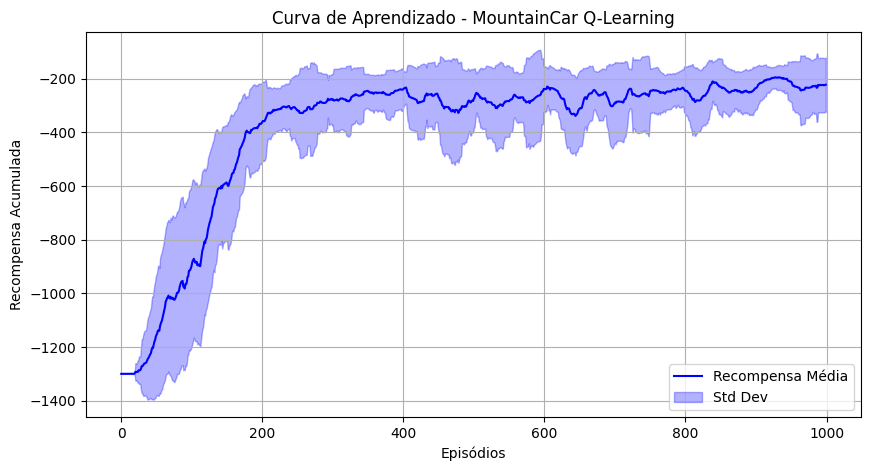

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que all_rewards seja uma lista de listas de shape (5, num_episodes)
# Exemplo (remova ou substitua pelos seus dados reais):
# all_rewards = [list_of_rewards_run1, list_of_rewards_run2, ..., list_of_rewards_run5]

# Converte all_rewards para um array numpy e depois para um DataFrame (cada coluna representa uma execução)
ql_mean_rewards = np.array(ql_mean_rewards)  # Converte para array numpy
df = pd.DataFrame(ql_mean_rewards.T)

# Aplica média móvel (rolling) com uma janela de 25 episódios para suavização
rolling_mean = df.rolling(window=25, min_periods=1).mean()
rolling_std = df.rolling(window=25, min_periods=1).std()

# Calcula a média e o desvio padrão das execuções, episódio a episódio
ql_mean_reward = rolling_mean.mean(axis=1)
ql_std_reward = rolling_std.mean(axis=1)

# Gera os índices dos episódios
episodes = np.arange(len(ql_mean_reward))

plt.figure(figsize=(10, 5))
# Plota a linha da recompensa média com Seaborn
sns.lineplot(x=episodes, y=ql_mean_reward, label="Recompensa Média", color="blue")
# Adiciona a área sombreada representando ±1 desvio padrão
plt.fill_between(episodes, ql_mean_reward - ql_std_reward, ql_mean_reward + ql_std_reward,
                 color="blue", alpha=0.3, label="Std Dev")

plt.xlabel("Episódios")
plt.ylabel("Recompensa Acumulada")
plt.title("Curva de Aprendizado - MountainCar Q-Learning")
plt.legend()
plt.grid(True)
plt.savefig('results/curva_de_aprendizado_qlearning_acumulado.jpg')
plt.show()


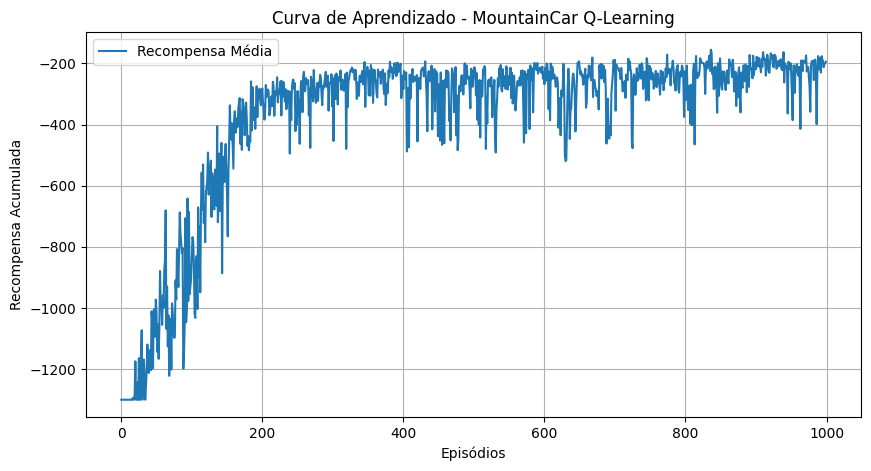

In [26]:
# Criar curva de aprendizado (média das recompensas por episódio)
ql_mean_rewards = np.mean(ql_mean_rewards, axis=0)

plt.figure(figsize=(10,5))
plt.plot(ql_mean_rewards, label="Recompensa Média")
plt.xlabel("Episódios")
plt.ylabel("Recompensa Acumulada")
plt.title("Curva de Aprendizado - MountainCar Q-Learning")
plt.legend()
plt.grid()

plt.savefig('results/curva_de_aprendizado_qlearning.jpg')
plt.show()


# Deep QLearning

In [27]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from DeepQLearning import DeepQLearningAgent
import csv

In [28]:
class DQNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  
        self.fc2 = nn.Linear(256, output_dim)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  

    def save(self, filename):
        torch.save(self.state_dict(), filename)

In [29]:
# Hiperparâmetros
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_dec = 0.995
episodes = 1000
batch_size = 64
memory_size = 10000
max_steps = 1300
alpha = 0.001

In [30]:
# Criando o ambiente
env = gym.make('MountainCar-v0')
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo usado: {device}")
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


Dispositivo usado: cpu
State space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space:  Discrete(3)


In [31]:
# Lista para armazenar recompensas de todas as execuções
dql_mean_rewards = []

# Executando o treinamento 5 vezes
N = 5  
for i in range(N):
    print(f"\n===== Treinamento {i+1}/{N} =====")
    
    model = DQNModel(env.observation_space.shape[0], env.action_space.n).to(device)
    optimizer = optim.Adam(model.parameters(), lr=alpha)
    loss_fn = nn.MSELoss()
    memory = deque(maxlen=memory_size)

    # Criando agente DQN
    DQN = DeepQLearningAgent(env, gamma, epsilon, epsilon_min, epsilon_dec, episodes, batch_size, memory, model, max_steps, device, loss_fn, optimizer)
    
    # Treinando o modelo
    rewards = DQN.train()
    dql_mean_rewards.append(rewards)

    # Salvando os pesos da rede neural
    model_path = f"models/dqn_mountaincar_{i+1}.pth"
    model.save(model_path)
    print(f"Modelo salvo: {model_path}")


===== Treinamento 1/5 =====


/Users/pedropertusi/Desktop/reinforcement-learning/06-deep-q-learning-versus-q-learning-PedroPertusi/DeepQLearning.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=self.device)
/Users/pedropertusi/Desktop/reinforcement-learning/06-deep-q-learning-versus-q-learning-PedroPertusi/DeepQLearning.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(next_state, dtype=torch.float32, device=self.device)
/Users/pedropertusi/Desktop/reinforcement-learning/06-deep-q-learning-versus-q-learning-PedroPertusi/DeepQLearning.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone(

Episódio: 1/1000. Score: -921.0
Episódio: 2/1000. Score: -1301.0
Episódio: 3/1000. Score: -1301.0
Episódio: 4/1000. Score: -1301.0
Episódio: 5/1000. Score: -1301.0
Episódio: 6/1000. Score: -836.0
Episódio: 7/1000. Score: -1301.0
Episódio: 8/1000. Score: -1301.0
Episódio: 9/1000. Score: -1301.0
Episódio: 10/1000. Score: -1301.0
Episódio: 11/1000. Score: -1301.0
Episódio: 12/1000. Score: -1301.0
Episódio: 13/1000. Score: -1301.0
Episódio: 14/1000. Score: -1301.0
Episódio: 15/1000. Score: -1301.0
Episódio: 16/1000. Score: -1301.0
Episódio: 17/1000. Score: -1301.0
Episódio: 18/1000. Score: -1301.0
Episódio: 19/1000. Score: -1301.0
Episódio: 20/1000. Score: -1301.0
Episódio: 21/1000. Score: -1301.0
Episódio: 22/1000. Score: -1301.0
Episódio: 23/1000. Score: -1301.0
Episódio: 24/1000. Score: -1301.0
Episódio: 25/1000. Score: -1301.0
Episódio: 26/1000. Score: -1301.0
Episódio: 27/1000. Score: -1301.0
Episódio: 28/1000. Score: -1301.0
Episódio: 29/1000. Score: -474.0
Episódio: 30/1000. Score: 

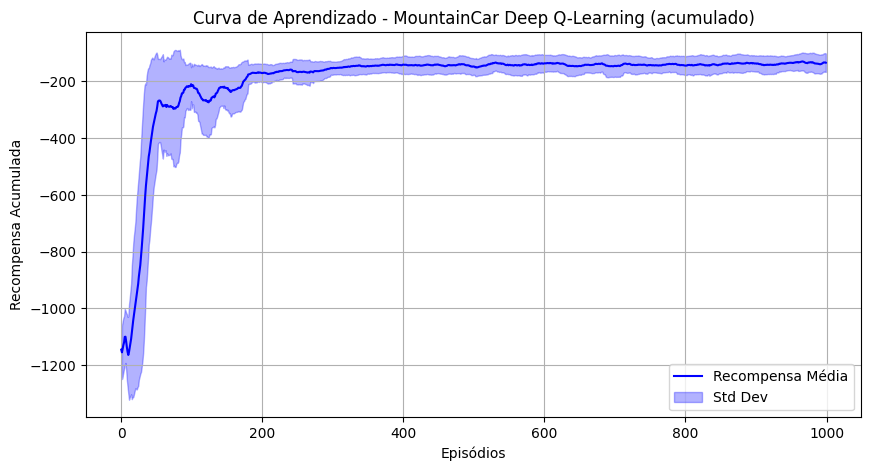

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que all_rewards seja uma lista de listas de shape (5, num_episodes)
# Exemplo (remova ou substitua pelos seus dados reais):
# all_rewards = [list_of_rewards_run1, list_of_rewards_run2, ..., list_of_rewards_run5]

# Converte all_rewards para um array numpy e depois para um DataFrame (cada coluna representa uma execução)
dql_mean_rewards = np.array(dql_mean_rewards)  # Converte para array numpy
df = pd.DataFrame(dql_mean_rewards.T)

# Aplica média móvel (rolling) com uma janela de 25 episódios para suavização
rolling_mean = df.rolling(window=25, min_periods=1).mean()
rolling_std = df.rolling(window=25, min_periods=1).std()

# Calcula a média e o desvio padrão das execuções, episódio a episódio
dql_mean_reward = rolling_mean.mean(axis=1)
dql_std_reward = rolling_std.mean(axis=1)

# Gera os índices dos episódios
episodes = np.arange(len(dql_mean_reward))

plt.figure(figsize=(10, 5))
# Plota a linha da recompensa média com Seaborn
sns.lineplot(x=episodes, y=dql_mean_reward, label="Recompensa Média", color="blue")
# Adiciona a área sombreada representando ±1 desvio padrão
plt.fill_between(episodes, dql_mean_reward - dql_std_reward, dql_mean_reward + dql_std_reward,
                 color="blue", alpha=0.3, label="Std Dev")

plt.xlabel("Episódios")
plt.ylabel("Recompensa Acumulada")
plt.title("Curva de Aprendizado - MountainCar Deep Q-Learning (acumulado)")
plt.legend()
plt.grid(True)
plt.savefig('results/curva_de_aprendizado_deepqlearning_acumulado.jpg')
plt.show()


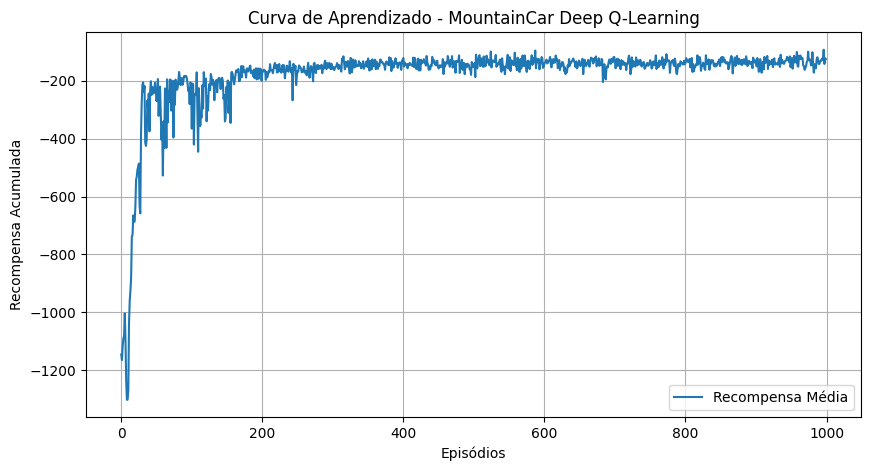

In [33]:
# Criando curva de aprendizado (média das recompensas por episódio)
dql_mean_rewards = np.mean(dql_mean_rewards, axis=0)

plt.figure(figsize=(10,5))
plt.plot(dql_mean_rewards, label="Recompensa Média")
plt.xlabel("Episódios")
plt.ylabel("Recompensa Acumulada")
plt.title("Curva de Aprendizado - MountainCar Deep Q-Learning")
plt.legend()
plt.grid()

plt.savefig('results/curva_de_aprendizado_dqlearning.jpg')
plt.show()


# Compare os resultados obtidos com o Q-Learning e o Deep Q-Learning usando um plot. Tente deixar claro no plot qual a meta de recompensa acumulada para o ambiente MountainCar.

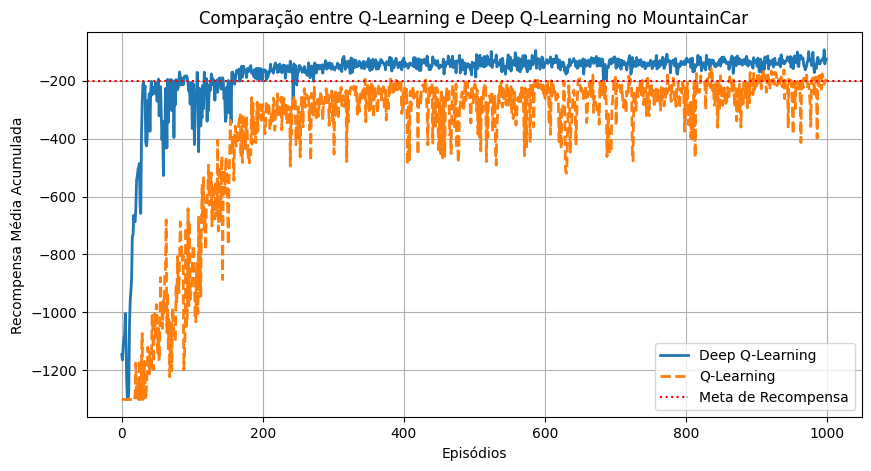

In [34]:
# Definição da meta de recompensa para o MountainCar (chegar ao topo)
goal_reward = -200  # valor necessário para resolver o ambiente

# Criar gráfico comparativo
plt.figure(figsize=(10, 5))
plt.plot(dql_mean_rewards, label="Deep Q-Learning", linestyle='-', linewidth=2)
plt.plot(ql_mean_rewards, label="Q-Learning", linestyle='--', linewidth=2)
plt.axhline(y=goal_reward, color='r', linestyle='dotted', label="Meta de Recompensa")

# Configurações do gráfico
plt.xlabel("Episódios")
plt.ylabel("Recompensa Média Acumulada")
plt.title("Comparação entre Q-Learning e Deep Q-Learning no MountainCar")
plt.legend()
plt.grid()

# Exibir o gráfico
plt.savefig('results/curva_de_aprendizado_comparacao.jpg')
plt.show()

# Crie outro gráfico que mostra o desempenho de ambos os agentes durante o processo de inferência, ou seja, quando o agente está atuando sem treinamento.

Q-table carregada de 'qtable/q_table_mountain_car_1.npy'.


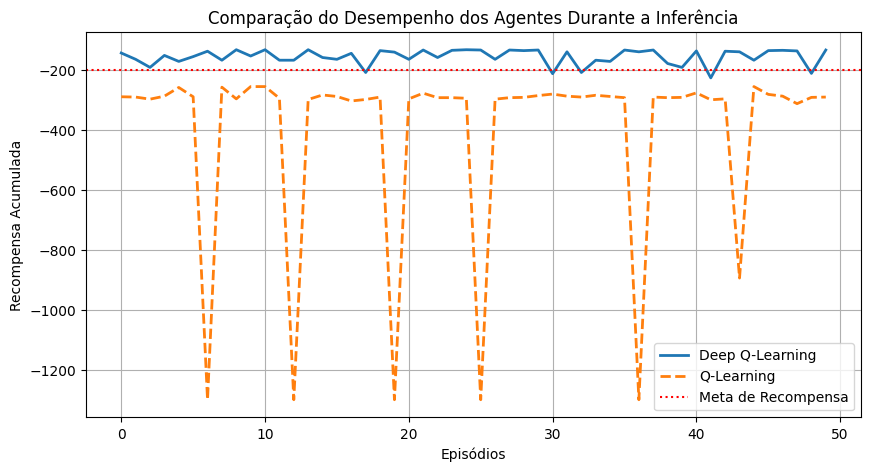

In [35]:
# Configurações
num_eval = 50  # Número de episódios de inferência
max_steps = 1300  # Número máximo de passos por episódio

# Criar ambiente
env = gym.make("MountainCar-v0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### ======= Testando Deep Q-Learning ======= ###
dql_rewards = []

# Carregando o modelo treinado
model = DQNModel(env.observation_space.shape[0], env.action_space.n).to(device)
model.load_state_dict(torch.load("models/dqn_mountaincar_1.pth", map_location=device))
model.eval()

# Executando inferência
for _ in range(num_eval):
    state, _ = env.reset()
    total_reward = 0
    done = False
    steps = 0

    while not done and steps < max_steps:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = torch.argmax(model(state_tensor)).item()
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state
        steps += 1

    dql_rewards.append(total_reward)

### ======= Testando Q-Learning ======= ###
ql_rewards = []

# Carregando a Q-table salva
ql_agent = QLearningAgent(env)
ql_agent.load_q_table("q_table_mountain_car_1")  # Nome do arquivo da Q-table

# Executando inferência
for _ in range(num_eval):
    state, _ = env.reset()
    state_adj = ql_agent.transform_state(state)
    total_reward = 0
    done = False
    steps = 0

    while not done and steps < max_steps:
        action = np.argmax(ql_agent.q_table[state_adj[0], state_adj[1]])
        next_state, reward, done, truncated, _ = env.step(action)
        state_adj = ql_agent.transform_state(next_state)
        total_reward += reward
        steps += 1

    ql_rewards.append(total_reward)

### ======= Gerando Gráfico Comparativo ======= ###
plt.figure(figsize=(10, 5))
plt.plot(dql_rewards, label="Deep Q-Learning", linestyle='-', linewidth=2)
plt.plot(ql_rewards, label="Q-Learning", linestyle='--', linewidth=2)
plt.axhline(y=-200, color='r', linestyle='dotted', label="Meta de Recompensa")

plt.xlabel("Episódios")
plt.ylabel("Recompensa Acumulada")
plt.title("Comparação do Desempenho dos Agentes Durante a Inferência")
plt.legend()
plt.grid()

plt.savefig('results/comparacao_inferencia.jpg')
plt.show()
